<a href="https://colab.research.google.com/github/Smjfirna/Arsitektur-Compration/blob/main/VGG16%20final/100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#Preprocessing
import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

#Model dan Augmentasi
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, Model, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, Dropout
import os
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications import VGG16

# Evaluasi
import torch
import torchvision.models as models
from thop import profile
from sklearn.metrics import confusion_matrix, classification_report

#Visualisasi
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"smjayyy","key":"8eb172e224d83c7b56b4a2ef349b7c0d"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
##link dataset in Kaggle.com
!kaggle datasets download -d smaranjitghose/corn-or-maize-leaf-disease-dataset

Dataset URL: https://www.kaggle.com/datasets/smaranjitghose/corn-or-maize-leaf-disease-dataset
License(s): copyright-authors
 86% 138M/161M [00:00<00:00, 197MB/s]
100% 161M/161M [00:00<00:00, 207MB/s]


In [6]:
!unzip -q corn-or-maize-leaf-disease-dataset.zip -d /content

In [7]:
dataset_dir = '/content/data'

In [8]:
print(os.listdir(dataset_dir))

['Gray_Leaf_Spot', 'Healthy', 'Blight', 'Common_Rust']


In [9]:
IMAGE_SIZE_vgg16 = 224

In [10]:
def make_data(label, DIR, img_list, label_list):
    for img in tqdm(os.listdir(DIR)):
        path = os.path.join(DIR, img)
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMAGE_SIZE_vgg16, IMAGE_SIZE_vgg16))
        img_list.append(np.array(img))
        label_list.append(str(label))

In [11]:
X = []
Z = []

In [12]:
for i, class_name in enumerate(['Common_Rust', 'Healthy', 'Gray_Leaf_Spot', 'Blight']):
    class_dir = os.path.join(dataset_dir, class_name)
    make_data(class_name, class_dir, X, Z)

100%|██████████| 1146/1146 [00:05<00:00, 197.58it/s]


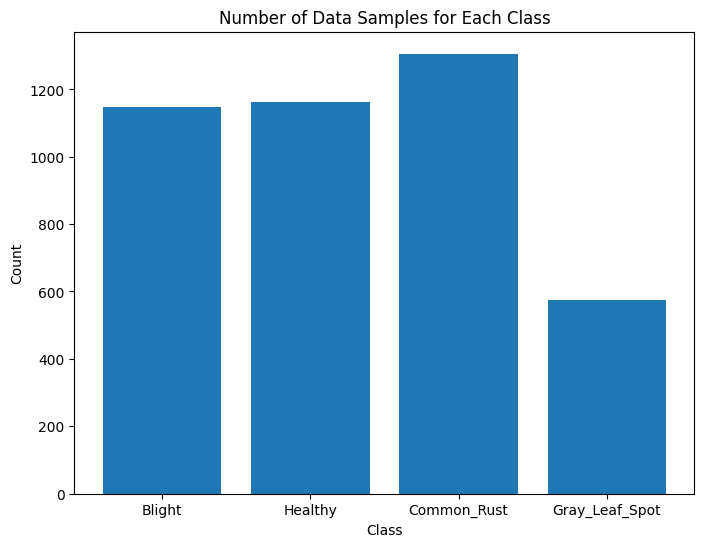

In [13]:
import matplotlib.pyplot as plt

# Menghitung jumlah data untuk setiap kelas
class_counts = {class_name: Z.count(class_name) for class_name in set(Z)}

# Menampilkan visualisasi jumlah data
plt.figure(figsize=(8, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Number of Data Samples for Each Class')
plt.show()

In [14]:
le = LabelEncoder()
Y = le.fit_transform(Z)
Y = to_categorical(Y, num_classes=len(le.classes_))

# Konversi ke array numpy
X = np.array(X)

# Memisahkan data menjadi data latih dan data uji
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print("Jumlah Data Train adalah :", len(X_train))
print("Jumlah Data Test adalah :", len(X_test))

Jumlah Data Train adalah : 3350
Jumlah Data Test adalah : 838


In [15]:
datagen = ImageDataGenerator(
    rotation_range=20,  # Rotasi gambar hingga 40 derajat
    zoom_range=0.2,  # Zoom-in/Zoom-out gambar
    horizontal_flip=True,  # Flipping horizontal gambar
    vertical_flip=True
)

datagen.fit(X_train)

In [16]:
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE_vgg16, IMAGE_SIZE_vgg16, 3))

# Membuat model Sequential
model_vgg16 = Sequential()
model_vgg16.add(vgg16)
model_vgg16.add(GlobalAveragePooling2D())
model_vgg16.add(Dense(4, activation='softmax'))

for layer in vgg16.layers:
    layer.trainable = False

model_vgg16.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

model_vgg16.summary()

history_resnet50ver2 = model_vgg16.fit(datagen.flow(X_train, Y_train), epochs=100, validation_data=(X_test, Y_test))

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 4)                 2052      
                                                                 
Total params: 14716740 (56.14 MB)
Trainable params: 2052 (8.02 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________
Epoch 1/100
105/105 [==============================] - 68s 544ms/step - loss: 2.3721 - accuracy: 0.4346 - val_loss: 1.8832 - val_accuracy: 0.5597


27/27 [==============================] - 3s 116ms/step


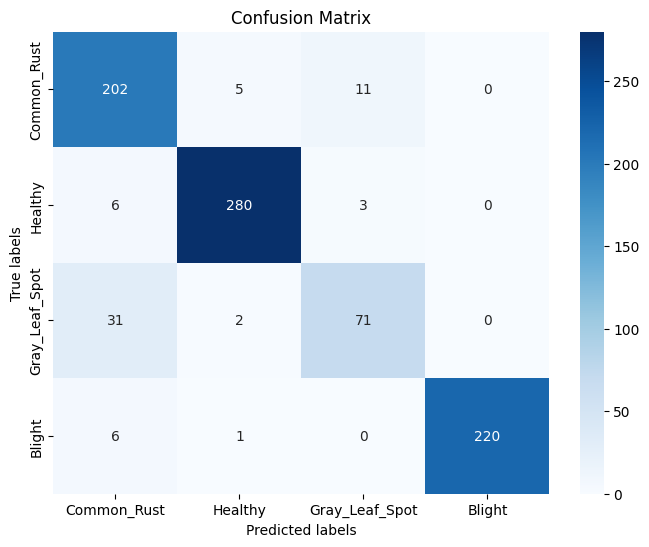


Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.93      0.87       218
           1       0.97      0.97      0.97       289
           2       0.84      0.68      0.75       104
           3       1.00      0.97      0.98       227

    accuracy                           0.92       838
   macro avg       0.91      0.89      0.89       838
weighted avg       0.92      0.92      0.92       838



In [17]:
Y_pred = model_vgg16.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_test, axis=1)

conf_matrix = confusion_matrix(Y_true, Y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Common_Rust', 'Healthy', 'Gray_Leaf_Spot', 'Blight'], yticklabels=['Common_Rust', 'Healthy', 'Gray_Leaf_Spot', 'Blight'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

class_report = classification_report(Y_true, Y_pred_classes)

print("\nClassification Report:")
print(class_report)

In [18]:
model = models.vgg16()

input = torch.randn(1, 3, 224, 224)

flops, params = profile(model, inputs=(input, ))
print(f"Estimasi FLOPS: {flops}")

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
Estimasi FLOPS: 15470314496.0
